# Gradient Geometry: Sentiment Analysis with RNNs

## Abstract

In this notebook we dive into gradient geometry of neural networks, tracked by ``ParameterGradientGeometry`` lens. We train severeal RNNs on twitter sentiment analysis dataset.
Most of the ideas in this notebook are taken from [Vanishing and Exploding Gradients](https://ai.gopubby.com/vanishing-and-exploding-gradients-5dcdf905c550) by Malcolm Lett, we highly advise you to read the article.

## Imports and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn import datasets
from sklearn.model_selection import train_test_split

RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

We willbe using [Twitter Sentiment Analysis Dataset ](https://www.kaggle.com/datasets/durgeshrao9993/twitter-analysis-dataset-2022) for this task. Each row contains anonymized tweet's text and a binary label if a tweet is negative.

In [2]:
df = pd.read_csv('twitter.csv', index_col='id')
train_df, val_df = train_test_split(
    df, random_state=RND_SEED, shuffle=True, test_size=0.2
)

Each tweet will be represented by a sequence of 25 tokens encoded ordinally from a vocabluary with 10k unique values.

In [3]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

MAX_TOKENS = 10000
vocab = build_vocab_from_iterator(yield_tokens(train_df['tweet']), specials=["<pad>", "<unk>"], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab["<unk>"])

PAD_IDX = vocab["<pad>"]

class TweetDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, max_len=25):
        self.df = df
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        global PAD_IDX
        text = self.df.iloc[idx]['tweet']
        label = self.df.iloc[idx]['label']
        tokens = self.vocab(self.tokenizer(text))
        tokens = tokens[:self.max_len] + [PAD_IDX] * (self.max_len - len(tokens))
        return torch.tensor(tokens), torch.tensor(label).float()

train_dataset = TweetDataset(train_df, vocab, tokenizer)
val_dataset = TweetDataset(val_df, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Next we define standard early stopping mechanism and generic functions for training and validation.

In [4]:
class EarlyStopper:
    def __init__(self, patience : int = 5, eps : float = 1e-3):
        self.loss = float('+inf')
        self.timer = 0
        self.eps = eps
        self.patience = patience

    def __call__(self, new_loss : float) -> bool:
        if self.loss - new_loss > self.eps:
            self.loss = new_loss
            self.timer = 0
            return False
        self.timer += 1
        return self.timer >= self.patience

def train_one_epoch(model, loss_fn, optimizer, dataloader=train_loader):
    for data, label in dataloader:
        pred = model(data)
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

@torch.no_grad
def validate_one_epoch(model, loss_fn, dataloader=val_loader, n_val=val_df.shape[0]):
    correctly_classified = 0
    for data, label in dataloader:
        pred = model(data)
        loss = loss_fn(pred, label)
        correctly_classified += pred.ge(0.5).float().eq(label).float().sum().item()
    return correctly_classified / n_val

## Gradient Geometry Lens

Monitorch allows to keep track of gradients with respect to both parameters and outputs of layers (``ParameterGradientGeometry`` and ``OutputGradientGeometry`` respectively). Output gradients are even hardered to interpret and lens usage is the same in principal, so we will not bother to discuss it.

``ParameterGradientGeometry`` allows to keep track of L2-norm of gradients and normalized inner product between consecutive batch-iteration gradients. Norm helps to analyse exploding and vanishing gradient problem, while inner product helps investigate oscilating gradients. Later is area of active research and it is not clear how to troubleshoot model variance produced by gradients; [Chedi Morchdi et al.](https://www.sci.utah.edu/~beiwang/publications/Mysterious_BeiWang_2023.pdf) show that neural networks learn only during oscilating phase.

To compare gradient norms between layers it is useful to have the same scale for norms, by providing ``normalize_by_size=True`` L2-norms are divided by square root of number of elements, hence computing RMS.

``ParameterGradientGeometry`` keeps track of every module that has all of the parameters listed during optimization, default are ``"weight"`` and ``"bias"``.

## RNN

Recurrent neural networks are famous for having gradient issues, thereofre we will plot gradient norms to examine those problems.

In [5]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics, ParameterGradientGeometry

loss_fn = nn.BCELoss()

inspector = PyTorchInspector(
    lenses = [
        LossMetrics(
            loss_fn=loss_fn,
            metrics=['val_accuracy']
        ),
        ParameterGradientGeometry(compute_adj_prod=False),
        ParameterGradientGeometry(
            parameters=['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'],
            compute_adj_prod=False
        )
    ]
)

Our models will consist of embedding layer for tokens, RNN and a fully connected layer with sigmoid activation for prediction. Last hidden state will be pushed to the fully connected layer for prediction.

In [6]:
class SentimentRNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, nonlinearity, vocab_size=MAX_TOKENS, pad_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity=nonlinearity, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.sigmoid(self.fc(hidden[-1])).reshape(-1)

Finally, we will train the network with tanh activation using Adam optimizer.

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [02:41<05:43, 10.10s/it]


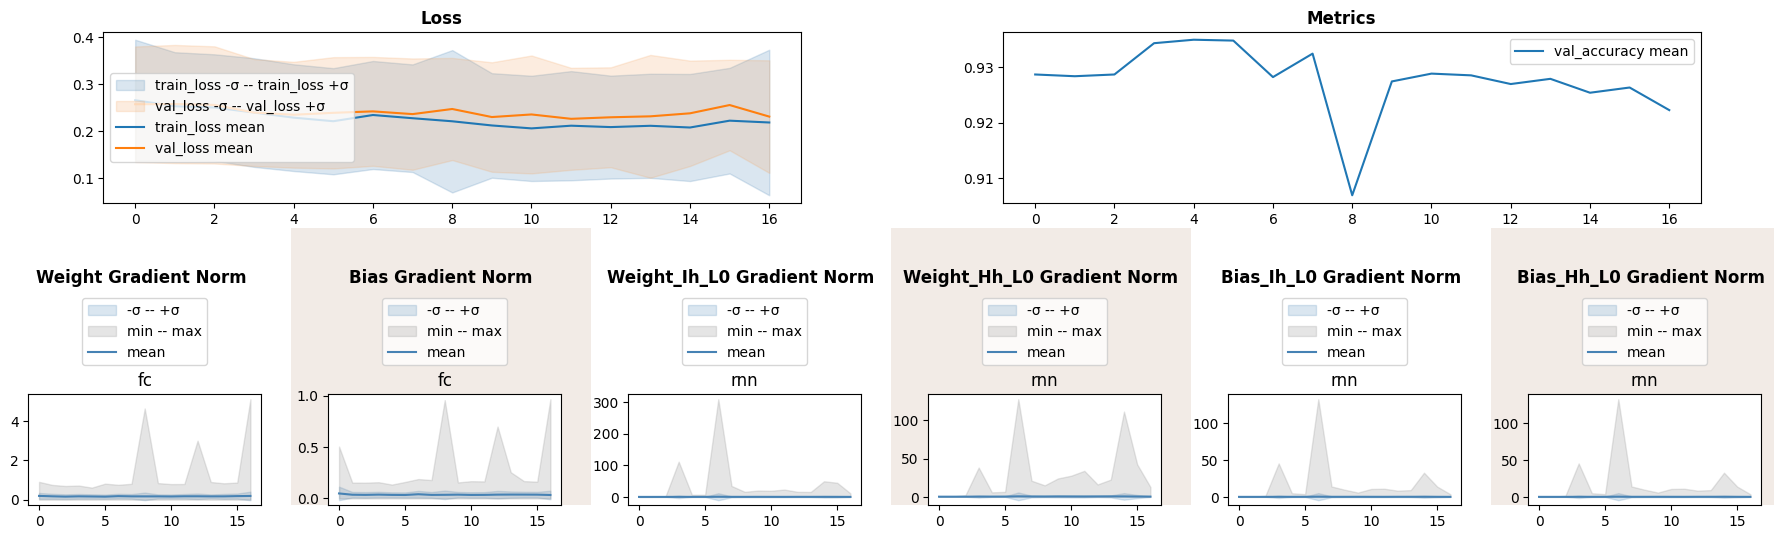

In [7]:
from tqdm import trange

rnn = SentimentRNN(embed_dim=32, hidden_dim=32, nonlinearity='tanh')
stopper = EarlyStopper()

inspector.attach(rnn)
optimizer = torch.optim.Adam(rnn.parameters())

N_EPOCH = 50
for epoch in trange(N_EPOCH):
    train_one_epoch(rnn, loss_fn, optimizer)
    val_acc = validate_one_epoch(rnn, loss_fn)
    
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    
    if stopper(inspector.lenses[0].loss(train=False)):
        break
fig = inspector.visualizer.show_fig()

We see that RNN parameters experience gradient explosion near epoch 7. Fully connected layer gradients have peaks of large magnitude later during roughly the same epochs. All in all, the whole model strugles to learn.

One of the reasons could be saturation of tanh unit, as it shrinks output norms under iterated composition. Next we will train the same network but with ReLU activation.

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [02:04<06:33, 10.35s/it]


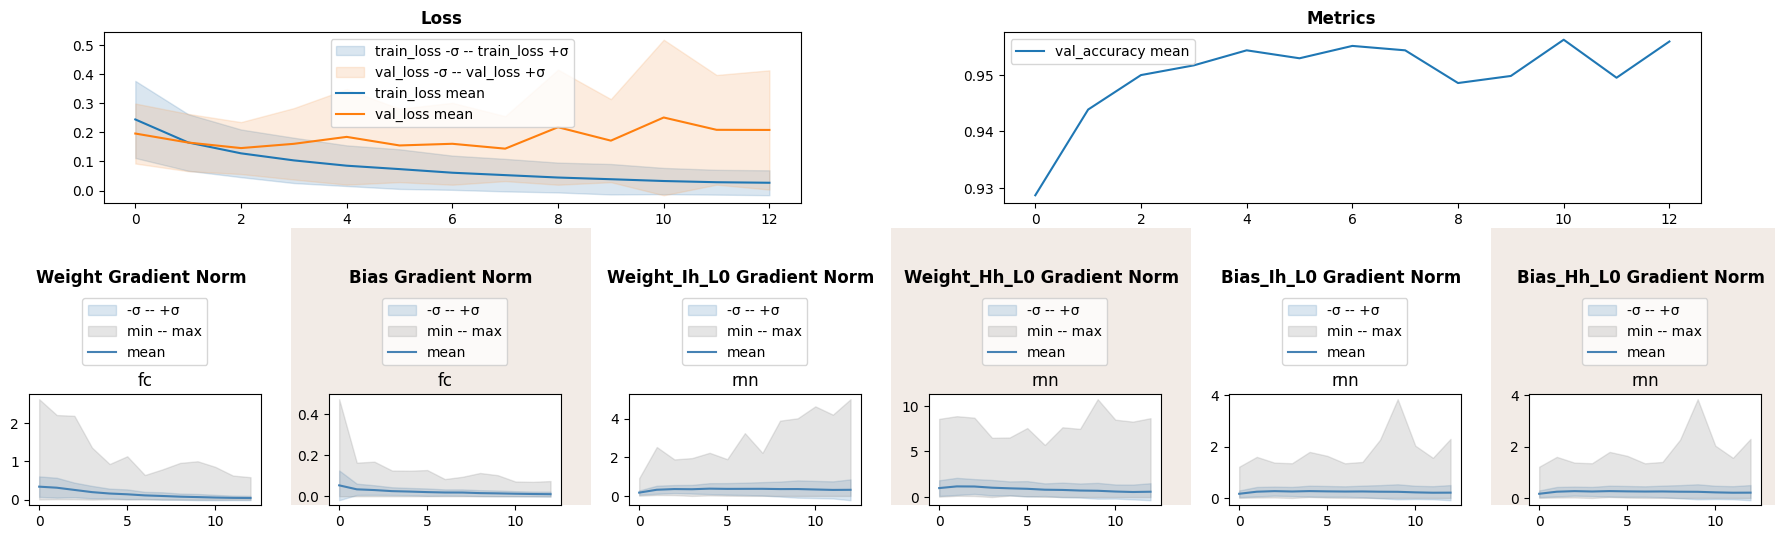

In [8]:
rnn = SentimentRNN(embed_dim=32, hidden_dim=32, nonlinearity='relu')
stopper = EarlyStopper()

inspector.attach(rnn)
optimizer = torch.optim.Adam(rnn.parameters())

N_EPOCH = 50
for epoch in trange(N_EPOCH):
    train_one_epoch(rnn, loss_fn, optimizer)
    val_acc = validate_one_epoch(rnn, loss_fn)
    
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    
    if stopper(inspector.lenses[0].loss(train=False)):
        break
fig = inspector.visualizer.show_fig()

We have made sufficient progress, still maximal norm during each epoch is large.

## LSTM

One of the proposed solutions for RNN gradient issues is to train LSTM, we hope to improve accuracy.

In [9]:
class SentimentLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size=MAX_TOKENS, pad_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cx) = self.lstm(embedded)
        return self.sigmoid(self.fc(hidden[-1])).reshape(-1)

 18%|███████████████████████████▋                                                                                                                              | 9/50 [01:33<07:04, 10.36s/it]


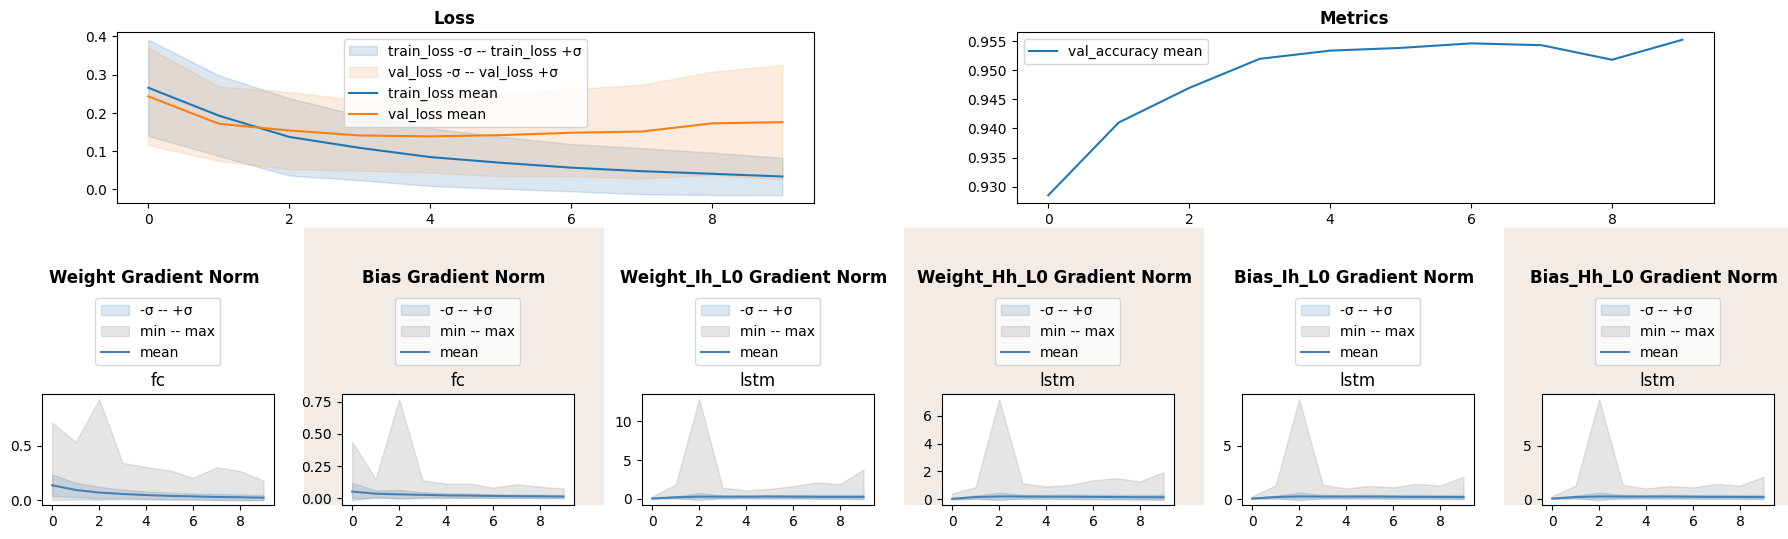

In [10]:
lstm = SentimentLSTM(embed_dim=32, hidden_dim=32)
stopper = EarlyStopper()

inspector.attach(lstm)
optimizer = torch.optim.Adam(lstm.parameters())

N_EPOCH = 50
for epoch in trange(N_EPOCH):
    train_one_epoch(lstm, loss_fn, optimizer)
    val_acc = validate_one_epoch(lstm, loss_fn)
    
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    
    if stopper(inspector.lenses[0].loss(train=False)):
        break
fig = inspector.visualizer.show_fig()

LSTM indeed has helped to bound gradient norm, though there has been a peak at epoch 2 and validation accuracy has not improved.

## What to Look for

* Gradient magnitudes should decline over course of training as model becomes closer to optimum.
* Spikes or steep valleys in norms signal gradient issues.

## Next Steps

* Read [an article](https://ai.gopubby.com/vanishing-and-exploding-gradients-5dcdf905c550) by Malcolm Lett.
* Take a look at other demonstration notebooks and documentation.
* Experiment with techniques tageting gradient flow such as normalization, residual and skip connections.